# 💼Fake Job Postings Detector Using NLP and Machine Learning🤝🏽

**Project Goal** : Detects fake job postings based on textual information such as job descriptions, company names, locations, and requirements

## 1.Importing Necessary Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, roc_curve, auc

from collections import Counter
from imblearn.over_sampling import SMOTE

## 2.Import Dataset

In [2]:
data = pd.read_csv('fake_job_postings.csv')

## 3.Data Preprocessing

In [3]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
data.shape

(17880, 18)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [6]:
numerical_columns = ['telecommuting','has_company_logo','has_questions','fraudulent']

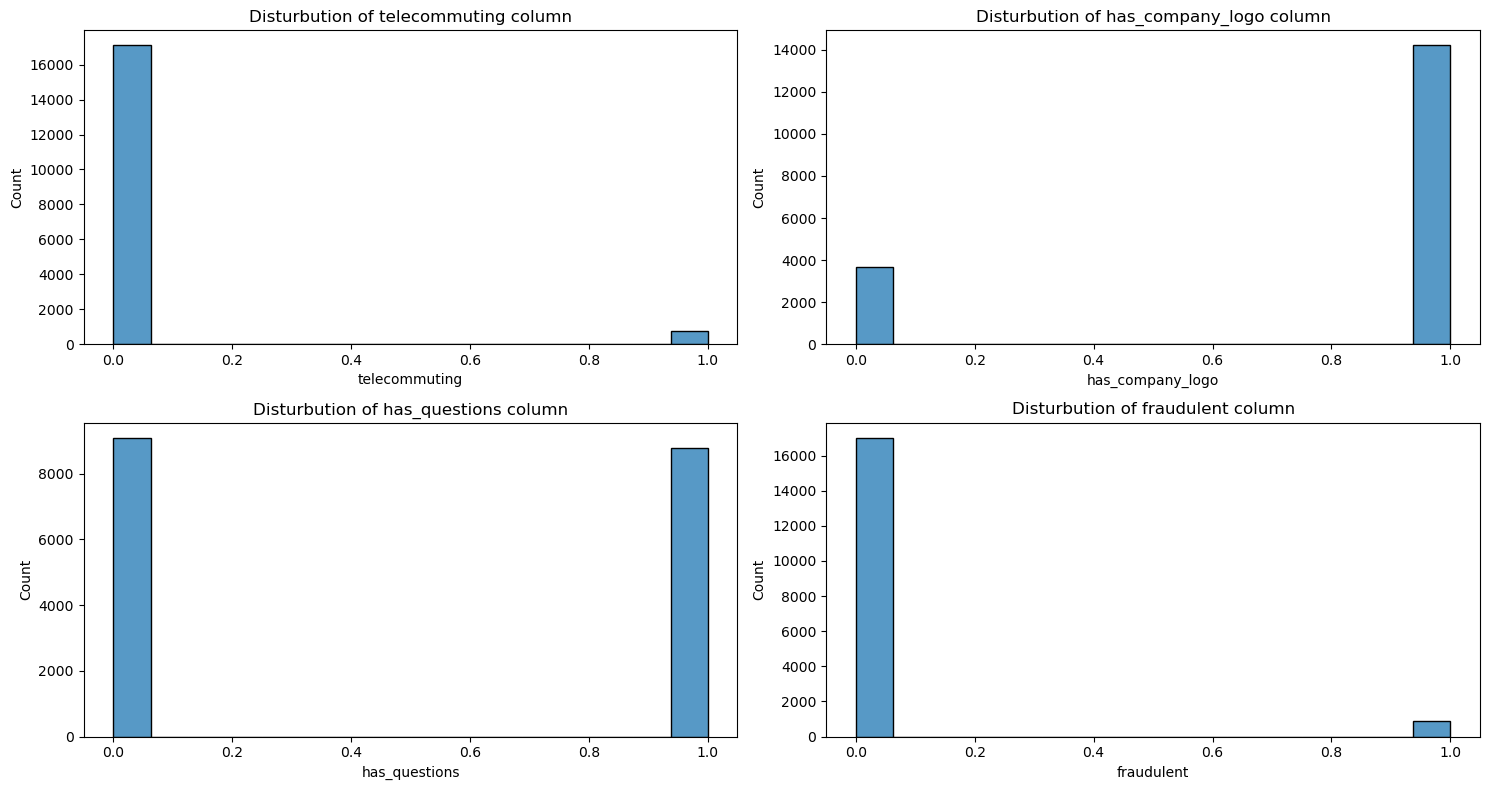

In [7]:
plt.figure(figsize=(15,8))
for index,col in enumerate(numerical_columns):
    plt.subplot(2,2,index+1)
    sns.histplot(data[col])
    plt.title(f'Disturbution of {col} column')
plt.tight_layout()
plt.show()

In [8]:
data.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
data.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

### There seem to be many missing values in the dataset

In [10]:
#Checking the missing values
Percent_of_missing_location = data['location'].isna().sum() / len(data['location']) * 100
print(np.round(Percent_of_missing_location,2))

1.94


### we have 1.94% of missing location data

In [11]:
Percent_of_missing_department = data['department'].isna().sum() / len(data['department']) * 100
print(np.round(Percent_of_missing_department,2))

64.58


### we have 64.58% of missing department data

In [12]:
Percent_of_missing_salary_range = data['salary_range'].isna().sum() / len(data['salary_range']) * 100
print(np.round(Percent_of_missing_salary_range,2))

83.96


### we have 83.96% of missing salary_range data

In [13]:
Percent_of_missing_company_profile = data['company_profile'].isna().sum() / len(data['company_profile']) * 100
print(np.round(Percent_of_missing_company_profile,2))

18.5


### we have 18.5% of missing company_profile data

In [14]:
Percent_of_missing_requirements = data['requirements'].isna().sum() / len(data['requirements']) * 100
print(np.round(Percent_of_missing_requirements,2))

15.08


### we have 15.08% of missing requirements data

In [15]:
Percent_of_missing_benefits = data['benefits'].isna().sum() / len(data['benefits']) * 100
print(np.round(Percent_of_missing_benefits,2))

40.34


### we have 40.34% of missing requirements data

In [16]:
Percent_of_missing_employment_type = data['employment_type'].isna().sum() / len(data['employment_type']) * 100
print(np.round(Percent_of_missing_employment_type,2))

19.41


### we have 19.41% of missing requirements data

In [17]:
Percent_of_missing_required_experience = data['required_experience'].isna().sum() / len(data['required_experience']) * 100
print(np.round(Percent_of_missing_required_experience,2))

39.43


### we have 39.43% of missing requirements data

In [18]:
Percent_of_missing_required_education = data['required_education'].isna().sum() / len(data['required_education']) * 100
print(np.round(Percent_of_missing_required_education,2))

45.33


### we have 45.33% of missing requirements data

In [19]:
Percent_of_missing_industry = data['industry'].isna().sum() / len(data['industry']) * 100
print(np.round(Percent_of_missing_industry,2))

27.42


### we have 27.42% of missing requirements data

In [20]:
Percent_of_missing_function = data['function'].isna().sum() / len(data['function']) * 100
print(np.round(Percent_of_missing_function,2))

36.1


### we have 36.1% of missing requirements data

In [21]:
total_precentage_missing_value = data.isnull().sum().sum()
total_cells = data.shape[0] * data.shape[1]
Overall_precentage_missing_value = (total_precentage_missing_value / total_cells) * 100
print(np.round(Overall_precentage_missing_value,2))

21.78


### we overall have 21.78% of missing data

In [22]:
data.duplicated().sum()

np.int64(0)

### There is no duplicate data in the dataset

In [23]:
cols = data.columns

In [24]:
for col in cols:
    print(f"{col} : {data[col].nunique()}")

job_id : 17880
title : 11231
location : 3105
department : 1337
salary_range : 874
company_profile : 1709
description : 14801
requirements : 11967
benefits : 6204
telecommuting : 2
has_company_logo : 2
has_questions : 2
employment_type : 5
required_experience : 7
required_education : 13
industry : 131
function : 37
fraudulent : 2


In [25]:
data['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

### Number of one class is higher then the another class in the dataset so we can see it is imbalanaced dataset

In [26]:
for col in cols:
    print(f"{col} : {data[col].unique()}")
    print()

job_id : [    1     2     3 ... 17878 17879 17880]

title : ['Marketing Intern' 'Customer Service - Cloud Video Production'
 'Commissioning Machinery Assistant (CMA)' ...
 'Senior Financial Analyst (Retail) ' 'Account Director - Distribution '
 'Project Cost Control Staff Engineer - Cost Control Exp - TX']

location : ['US, NY, New York' 'NZ, , Auckland' 'US, IA, Wever' ...
 'US, CA, los Angeles' 'CA, , Ottawa' 'GB, WSX, Chichester']

department : ['Marketing' 'Success' nan ... 'Admin - Clerical' 'Administrative Dept'
 'Hospitality']

salary_range : [nan '20000-28000' '100000-120000' '120000-150000' '50000-65000'
 '40000-50000' '60-80' '65000-70000' '75-115' '75000-110000' '17000-20000'
 '16000-28000' '95000-115000' '15000-18000' '50000-70000' '45000-60000'
 '30000-40000' '70000-90000' '10000-14000' '50-110' '28000-45000'
 '0-34300' '35000-40000' '9-Dec' '44000-57000' '18500-28000' '55000-75000'
 '30000-35000' '0-0' '20000-40000' '360000-600000' '50000-80000'
 '80000-100000' '52000-780

In [27]:
#Dropping irrelavant columns
data.drop(columns=['job_id','salary_range','telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function'],inplace=True,axis=1)

In [28]:
cols = data.columns
cols

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'fraudulent'],
      dtype='object')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            17880 non-null  object
 1   location         17534 non-null  object
 2   department       6333 non-null   object
 3   company_profile  14572 non-null  object
 4   description      17879 non-null  object
 5   requirements     15184 non-null  object
 6   benefits         10668 non-null  object
 7   fraudulent       17880 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 1.1+ MB


In [30]:
total_miss = data.isna().sum().sum()
total_dimension = data.shape[0] * data.shape[1]
print((total_miss / total_dimension) * 100)

17.554530201342285


In [31]:
# Fill NaN with empty string for text fields
data.fillna("", inplace=True)

In [32]:
# save my cleaned df
cleaned_df = data.copy()
cleaned_df.to_csv('cleaned_df.csv', index=False)

In [33]:
# Combine multiple text columns into one
data['combine_text'] = data['title'] + " " + data['location'] + " " + data['company_profile'] + " " +data['description'] + " " + data['requirements'] + " " + data['benefits']

In [34]:
data.head()

,title,location,department,company_profile,description,requirements,benefits,fraudulent,combine_text
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"Marketing Intern US, NY, New York We're Food52..."
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,"Customer Service - Cloud Video Production NZ, ..."
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,"Account Executive - Washington DC US, DC, Wash..."
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."


## 4.Lemmatizaion

In [35]:
stop_words = set(stopwords.words('english')) # nltk stop words
lemmatizer = WordNetLemmatizer() # nltk Lemmatization funtion

In [36]:
# Text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [37]:
type(data['combine_text'])

pandas.core.series.Series

In [38]:
data['clean_text'] = data['combine_text'].apply(clean_text)

In [39]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=100) 

X = vectorizer.fit_transform(data['clean_text']) # Independent variables

y = data['fraudulent']  # Target(Dependant) variable

In [40]:
# Over Sampling
smote_sample = SMOTE()
X_smote, y_smote = smote_sample.fit_resample(X, y)
print("Oversampled class distribution:", Counter(y_smote))

Oversampled class distribution: Counter({0: 17014, 1: 17014})


In [41]:
#Train test split
X_train,X_test,y_train,y_test = train_test_split(X_smote,y_smote,random_state=42,test_size=0.3)

## 5.Model Building

In [42]:
#Logistic Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train,y_train)

LogisticRegression()

In [43]:
y_pred_logistic = logistic_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_logistic))
print("\nROC_AUC_Score: ", roc_auc_score(y_test, y_pred_logistic))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      5105
           1       0.81      0.86      0.84      5104

    accuracy                           0.83     10209
   macro avg       0.83      0.83      0.83     10209
weighted avg       0.83      0.83      0.83     10209


ROC_AUC_Score:  0.832895614509102


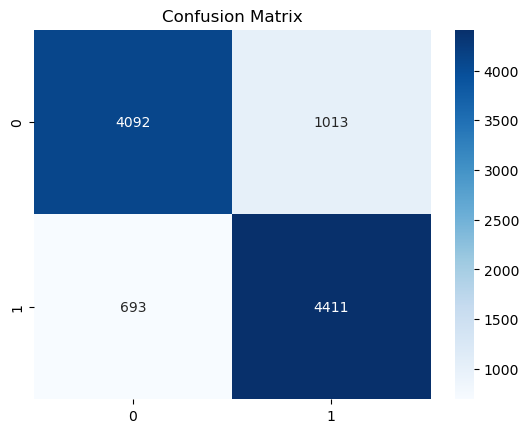

In [44]:
#Confusion matrix for Logistic Model
con_matrix = confusion_matrix(y_test,y_pred_logistic)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
sns.heatmap(con_matrix,annot=True,cmap='Blues',fmt='d')
plt.show()

In [45]:
#Support vector classification
svc_model = SVC()
svc_model.fit(X_train,y_train)

SVC()

In [46]:
y_pred_svc = svc_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svc))
print("\nROC_AUC_Score: ", roc_auc_score(y_test, y_pred_svc))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      5105
           1       0.99      1.00      1.00      5104

    accuracy                           1.00     10209
   macro avg       1.00      1.00      1.00     10209
weighted avg       1.00      1.00      1.00     10209


ROC_AUC_Score:  0.995886270759198


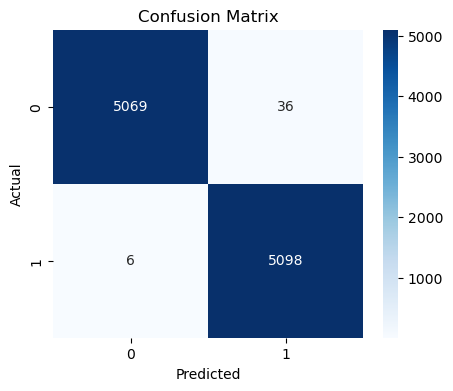

In [47]:
# Confusion Matrix for Support vector classification
cm = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [48]:
# Gradient Boosting Classifier
gdc_model = GradientBoostingClassifier()
gdc_model.fit(X_train,y_train)

GradientBoostingClassifier()

In [49]:
y_pred_gdc = gdc_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test,y_pred_gdc))
print("\nROC_AUC_Score: ", roc_auc_score(y_test, y_pred_gdc))


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      5105
           1       0.92      0.94      0.93      5104

    accuracy                           0.93     10209
   macro avg       0.93      0.93      0.93     10209
weighted avg       0.93      0.93      0.93     10209


ROC_AUC_Score:  0.9298667826735728


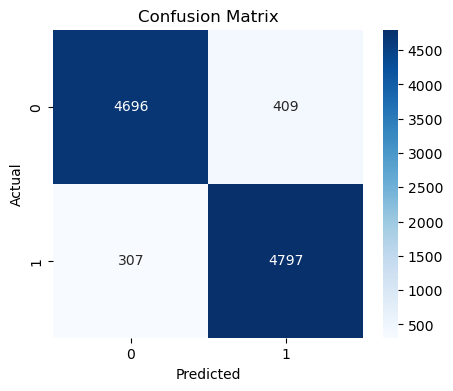

In [50]:
# Confusion Matrix for Gradient Boosting Classifier
cm = confusion_matrix(y_test, y_pred_gdc)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [51]:
from xgboost import XGBClassifier

xgboost_model = XGBClassifier()
xgboost_model.fit(X_train,y_train)

y_pred_xgb = xgboost_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test,y_pred_xgb))
print("\nROC_AUC_Score: ", roc_auc_score(y_test, y_pred_xgb))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5105
           1       0.98      0.98      0.98      5104

    accuracy                           0.98     10209
   macro avg       0.98      0.98      0.98     10209
weighted avg       0.98      0.98      0.98     10209


ROC_AUC_Score:  0.9807034639344916


In [52]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Get the predicted probabilities for the positive class
y_pred_proba_xgb = xgboost_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve values (fpr, tpr, thresholds)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_xgb)

# Calculate AUC score using the fpr and tpr from roc_curve
auc_score = auc(fpr, tpr)

print("\nAUC Score:", auc_score)
print("\nROC Curve values (fpr, tpr):", fpr, tpr)


AUC Score: 0.9977257375675086

ROC Curve values (fpr, tpr): [0.         0.         0.         ... 0.99745348 0.99784525 1.        ] [0.00000000e+00 1.95924765e-04 1.17554859e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


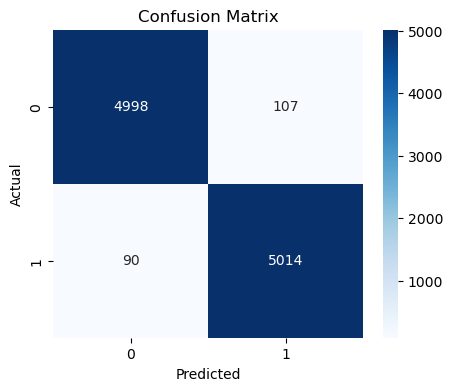

In [53]:
# Confusion Matrix for Gradient Boosting Classifier
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

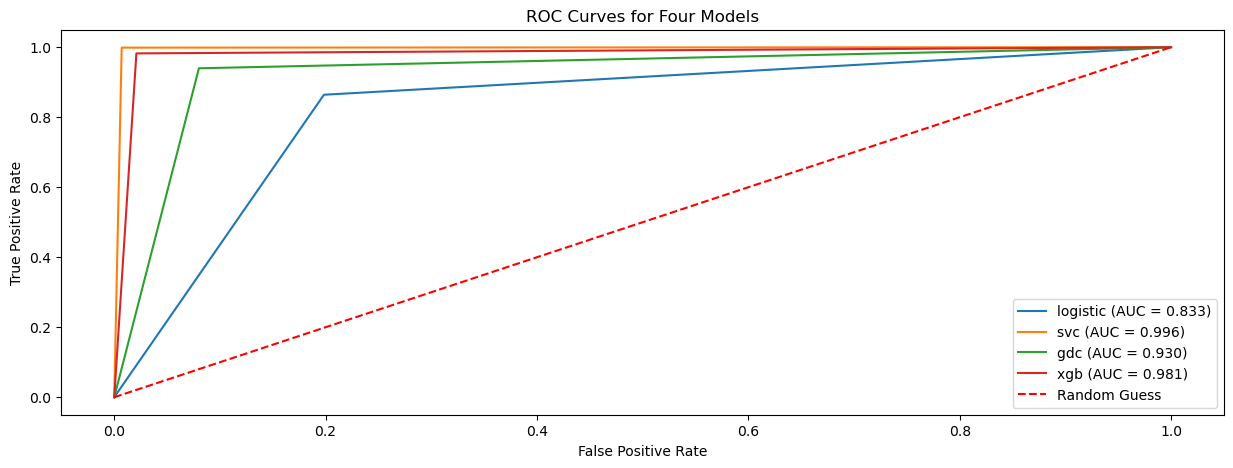

In [54]:
# ROC Curve For Three Models
test_df = pd.DataFrame({'true' : y_test,'logistic' : y_pred_logistic,'svc' : y_pred_svc,'gdc' : y_pred_gdc,'xgb' : y_pred_xgb})

plt.figure(figsize=(15,5))
for model in ['logistic','svc','gdc','xgb']:
    fpr,tpr,_ = roc_curve(test_df['true'],test_df[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Four Models')
plt.legend()
plt.show()

## 6.Saving the model

In [55]:
import joblib

In [56]:
best_model = svc_model
vectorizer_model = vectorizer

filename = 'svc_model.pkl'
filename_vectorizer = 'vectorizer_model.pkl'


with open(filename_vectorizer,'wb') as file:
    joblib.dump(vectorizer_model,file)

print(f"✅ Model saved as {filename_vectorizer}")

with open(filename,'wb') as file:
    joblib.dump(best_model,file)

print(f"✅ Model saved as {filename}")


✅ Model saved as vectorizer_model.pkl
✅ Model saved as svc_model.pkl


In [57]:
with open(filename,'rb') as f:
    model = joblib.load(f)
print(model)

with open(filename_vectorizer,'rb') as f:
    vectorizer = joblib.load(f)
print(vectorizer)

SVC()
TfidfVectorizer(max_features=100)


In [58]:
# Example: Predict on new job posting
new_job = ["""
    Only the best need apply...We are working with a very forward thinking organisation in the advertising sector who have asked us to identify 4-5 experienced telesales individuals to add to their successful team. They have secured a long-term project that has enabled them to recruit the best sales people in the West Yorkshire area and keep them going for years.Tenacity is the key word here, we need individuals who have the experience and skills to overcome objections professionally and successfully, one who won't let their head drop after they are hung up on, sworn to etc.WE NEED SALES ANIMALS.The product and brand is very strong and the company pride themselves on their outstanding success to date. You will be able to demonstrate a proven record of accomplishment in sales and target achievement. We would like you to be fearless and hungry. If you can get to Huddersfield Town Centre and work from 08.30 to 17.00 and have the skills required, apply now.Basic salary to Â£18KCommission currently averaging Â£1K per month but top sales people like you could earn Â£2K+ in commission with relative ease.
""",
    """
    mechanical assembly test technician u tx houston corporate overviewaker solution global provider product system service oil gas industry engineering design technology bring discovery production maximize recovery petroleum field employ approximately people country go urlfafceadeaecaedbdfefaae information business people valueswe looking individual prepared take position position within aker solution also position exciting challenge global oil gas industry face futureaker solution north america location houston mobile bakersfield calgary st john looking talented individual strengthen team support ambitious growth plan within oil gas marketresponsibilities tasksgeneral summary general supervision performs complex mechanical assembly operation often close tolerance working written verbal instruction us hand tool power tool measuring device individual shall maintain general awareness environmental aspect related impact assigned work activitiesessential functionsperforms combination following duty assembly mechanical equipmentâ€¢ inspects part work order brought warehouse damage record traceability work order â€¢ assembles product per specified procedure quality requirementsâ€¢ able set test equipment facilitate required test proceduresâ€¢ able flush line perform cleanliness test flushed line minimal supervisionâ€¢ able perform hydro gas fat test supervisionâ€¢ able troubleshoot equipment failuresâ€¢ able interact engineering assembly andor test procedure bom change requiredâ€¢ able interact rd party inspector customer relating product â€¢ sign responsible proper documentation step procedure performedâ€¢ performs intermediate assembly task cleaning stamping etchingâ€¢ mark andor tag component stock inventory tracked identifiedâ€¢ maintains clean safe work areaâ€¢ may assigned perform duty listed qualification amp personal attribute high school diploma equivalent three year experience involving assembly test subsea equipment similar product must able read engineering drawing must able work independantly offerâ€¢ friendly colleague industry bright futureâ€¢ environment encouraged develop skill share knowledge colleaguesâ€¢ competitive benefit strong focus worklife balanceaker solution leading global oil service company year industrial history successful development today employee country growing company developing market emerging region north america aker solution operates eight business unit creating many opportunity employee customer joining aker solution work valued member team tackling challenging work looking opportunity innovate position enjoy business casual environment flexible work schedule competitive benefit beginning first daywe equal opportunity employer discriminate applicant due race ethnicity gender veteran status basis disability federal state local protected class
""",
    """
    Interface with customers via inbound or outbound calls or the Internet for the purpose of resolving routine problems with products or services.Greet customers in a courteous, friendly, and professional manner using agreed upon procedures.Listen attentively to customer needs and concerns; demonstrate empathyClarify customer requirements; probe for and confirm understanding of requirements or problemMeet customer requirements through first contact resolutionConfirm customer understanding of the solution and provide additional customer education as neededPrepare complete and accurate work and update customer fileCommunicate effectively with individuals/teams in the program to ensure high quality and timely expedition of customer requestsEffectively transfer misdirected customer requests to an appropriate party. Contribute ideas on ways to resolve problems to better serve the customer and/or improve productivityParticipate in activities designed to improve customer satisfaction and business performanceOccasionally use decision-support tools to answer questionsSolve problems that are sometimes unstructured and that may require reliance on conceptual thinkingOffer solutions to issues that are often non-standard/non-routine and require some clarificationMaintain broad knowledge of client products and services
""",
    """
    AccionÂ  is currently seeking a professional individual enthusiastic about customer service and fashion. We are looking for someone focused on creating an exceptional customer service and shopping experience for our Accion customer.Â Â Â  Responsibilities:Welcome and greet customers, modeling a positive customer service spirit, exhibiting a friendly and helpful attitude with customers and associates.Answer customer questions regarding products and services; assist customers with buying decisions.Operate cash registers to complete customer transactions.Display merchandise and maintain a clean shopping area to maximize store appeal.Assist in the receiving and of new merchandise from vendors.Prepare merchandise for the selling floor.Assist in minimizing loss of company assets.Contribute to team efforts.Â Â 
""",
    """
    The Senior Systems Engineer is highly experienced in architecting, developing, and monitoring application systems. They will work on projects alone and in team environments to aid in the support of Well Aware internal and external products.
"""]

# Preprocess the text (use the same function you used during training)
cleaned_job = []
for i in new_job:
    cleaned_job.append(clean_text(i))

for i in range(len(cleaned_job)):
    # Transform with the same TF-IDF vectorizer
    X_new = vectorizer.transform([cleaned_job[i]])
    
    # Predict
    prediction = best_model.predict(X_new)
    print(f"Prediction for {i}: ", "Fake" if prediction[0]==1 else "Real")

Prediction for 0:  Real
Prediction for 1:  Fake
Prediction for 2:  Fake
Prediction for 3:  Fake
Prediction for 4:  Real
